Handling Missing Data

First, looking for null values that may be an issue later.

In [ ]:

import pandas as pd
import seaborn as sns

# Load and inspect a dataset
dataset = 'titanic'  # You can change this to any dataset available in seaborn
df = sns.load_dataset(dataset)
print(f"\nLoaded '{dataset}' dataset:")

# Identifying missing data
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

# Combine into a single DataFrame for better visibility
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percent
})

print("\nMissing Data Summary:")
print(null_summary)

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())


Then, dropping nulls, if acceptable to the outcome requirement.

In [ ]:
import pandas as pd
import seaborn as sns

# Load dataset
df = sns.load_dataset('taxis')

# SQL: SELECT * FROM table WHERE column IS NOT NULL
print("\nDropping rows with nulls in 'payment':")
df.dropna(subset=['payment'])


Or, filling the null fields with a default value.

| Situation                                                                  | Use `.dropna()`                         | Use `.fillna()`                                       |
| -------------------------------------------------------------------------- | --------------------------------------- | ----------------------------------------------------- |
| **Missing value is critical** (e.g., ID, timestamp, target variable in ML) | ✅ Yes — can't proceed without it        | ❌ Don't guess missing data                            |
| **Column is not essential** (e.g., optional comments)                      | ✅ OK to drop those rows                 | ✅ Or fill with placeholder like `'None'`              |
| **Small number of missing rows** (e.g., <5% of data)                       | ✅ Drop to simplify handling             | ✅ Fill to preserve rows if every row matters          |
| **Large % missing**                                                        | ❌ Dropping may throw away too much data | ✅ Filling avoids data loss                            |
| **Statistical modeling / ML inputs**                                       | ❌ Dropping can bias the sample          | ✅ Fill numerically (e.g., with mean/median) or flag   |
| **Column will be converted to categorical**                                | ❌ Drop only if category is essential    | ✅ Fill with placeholder like `'Unknown'` or `'Other'` |

In the case below, filling null payments with 'None' instead.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

# Load dataset
df = sns.load_dataset('taxis')

# SQL: UPDATE table SET column = 'Default' WHERE column IS NULL
df['payment'] = df['payment'].fillna('None') # Avoid `inplace=True` in Pandas to prevent modifying the original DataFrame directly, and will not work in Pandas 3.0+.
print("\nFilling nulls in 'payment' with 'None':")
filled_count = (df['payment'] == 'None').sum()  # Count how many were filled
print(f"{filled_count} rows filled with 'None'.")
sample_none_rows = df[df['payment'] == 'None'].sample(5, random_state=1) # Show somw sample rows where 'payment' was filled with 'None' to review the changes
print("\nSample rows where 'payment' was filled with 'None':")
print(sample_none_rows)



Side note:

**random_state=1 — What Does It Do?**

In pandas (and many other libraries like NumPy and scikit-learn), random_state is a seed value that controls the randomness of operations like .sample().

✅ Why use random_state?
By default, .sample() selects random rows differently every time you run the code.
If you set random_state, you'll get the same random rows every time.

*Example*: `df.sample(3, random_state=1)`

*This will always return the same 3 rows (as long as the DataFrame doesn't change), because random_state=1 fixes the random number generator.


| Scenario                        | Benefit                           |
| ------------------------------- | --------------------------------- |
| Debugging or teaching           | Everyone sees the same result     |
| Reproducible analysis / reports | Results don’t change between runs |
| Unit testing or comparison      | Same sample for fair comparison   |


______
Fill with statistical measures like `.mean()` (average), `.median()` (middle value), or `.mode()` (most frequent value) 

In [ ]:
import pandas as pd
import seaborn as sns

# Load dataset
df = sns.load_dataset('planets')

# Step 1: Save the mean value used to fill - this is useful for later reference, so I can show the filled rows
mean_value = df['orbital_period'].mean()

# Step 2: Fill missing values (already done)
df['orbital_period'] = df['orbital_period'].fillna(mean_value)

# Step 3: Show rows where orbital_period equals the mean (i.e., likely filled)
sample_filled = df[df['orbital_period'] == mean_value].sample(5, random_state=1)

print("Sample rows where 'orbital_period' was filled with the mean:")
print(sample_filled)

_____
Forward fill (`ffill`) and backward fill (`bfill`) are useful when missing values can logically be carried over from nearby entries — especially in time series or ordered data.

In [ ]:
import pandas as pd
import seaborn as sns

# Load dataset
df = sns.load_dataset('titanic')

# Nulls before fill
print("Nulls before fill:")
print(df[['embarked', 'deck']].isnull().sum())

# Before filling, mark nulls
was_null_embarked = df['embarked'].isnull()
was_null_deck = df['deck'].isnull()

# Fill missing values
df['embarked'] = df['embarked'].ffill()
df['deck'] = df['deck'].bfill()


# Show rows that were filled
print("\nFilled 'embarked':")
print(df[was_null_embarked])

print("\nFilled 'deck':")
print(df[was_null_deck])


✅ When to Use Forward Fill (`ffill`) or Backward Fill (`bfill`)

🔁 Forward Fill (`ffill`)
Fills each missing value with the last known non-null value going downward.

💡 Good Use Cases:
 - Scenario	 & Why `ffill` Makes Sense
 - Stock prices, sensor readings	If a value is missing at 9:02 AM, assume it's the same as 9:01 AM
 - Form or survey data	If one person’s name is known for the first row, carry it forward for grouped rows
 - Event logs or session tracking	Carry forward the session/user ID until a new one appears

🔁 Backward Fill (`bfill`)
Fills each missing value with the next known value going upward.

💡 Good Use Cases:
 - Scenario & Why `bfill` Makes Sense
 - Filling labels in grouped forms	First row missing a label can take from the next filled row
 - Forecasting models	When preparing lag features for ML, bfill can help with alignment
 - Propagating future-known values (rare)	Useful when data is collected out of order and future is known

⚠️ Use With Caution When:
 - Data is not ordered — fill direction will be misleading.
 - Missing values indicate something meaningful (e.g., skipped measurement).
 - You could be propagating wrong data, especially over long gaps.



_____________________
In Python, the `.interpolate()` method is used with pandas DataFrames or Series to fill in missing (NaN) values by estimating them using other values in the data. This is especially helpful in time series data or when dealing with incomplete datasets.

**When to Use .interpolate()**

- Time series data with gaps
- Sensor or scientific data needing smoothing
- Filling missing values in a more intelligent way than .fillna()

| Feature    | `.fillna()`                 | `.interpolate()`                          |
| ---------- | --------------------------- | ----------------------------------------- |
| Simplicity | Direct and fast             | More sophisticated                        |
| Logic      | Fixed values or copy nearby | Estimate values based on surrounding data |
| Use Case   | Defaults, categories        | Time series, numerical trends             |


In [ ]:
import pandas as pd

# Load and pivot data
flights = sns.load_dataset("flights")
pivot = flights.pivot(index="month", columns="year", values="passengers")

# Simulate missing data
pivot.loc["July", 1951] = None
pivot.loc["December", 1955] = None

# Interpolate missing values (column-wise: year)
filled = pivot.interpolate(axis=1)

print(filled.loc[["July", "December"], [1951, 1955]])

**When Data Filling Can Be Justified**
 -- Small gaps in continuous numeric data (like temperature, stock prices) where trends are smooth.
 -- Missing sensor readings due to technical glitches.
 -- Form inputs where defaults are known or categorical values are missing (e.g., filling "Unknown").


In Python, the .interpolate() method is used with pandas DataFrames or Series to fill in missing (NaN) values by estimating them using other values in the data. This is especially helpful in time series data or when dealing with incomplete datasets.

| Parameter         | Description                                                                                                                                       |
| ----------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| `method`          | Method of interpolation. Common options: `'linear'`, `'time'`, `'index'`, `'polynomial'`, `'spline'`, `'pad'`, `'nearest'`, `'barycentric'`, etc. |
| `axis`            | 0 for rows (default), 1 for columns                                                                                                               |
| `limit`           | Max number of consecutive `NaN` to fill                                                                                                           |
| `inplace`         | Whether to modify the original object                                                                                                             |
| `limit_direction` | Direction: `'forward'`, `'backward'`, `'both'`                                                                                                    |

💡 Best Practices to Avoid “Messing Up” Your Data

| Tip                                  | Description                                                    |
| ------------------------------------ | -------------------------------------------------------------- |
| **Understand the cause of `NaN`**    | Is it missing at random? Systematic? Required?                 |
| **Use domain knowledge**             | Only fill values when it logically makes sense.                |
| **Document imputation**              | Keep track of where and how you filled values.                 |
| **Flag filled values**               | Create a separate column indicating which values were imputed. |
| **Compare with and without filling** | See how results change — sensitivity testing is crucial.       |


*Side note:* 
**pandas `.pivot()` – Reshape Data**

The `.pivot()` method in **pandas** reshapes a DataFrame by turning unique values from one column into new columns.

**🔧 Syntax**

```python
DataFrame.pivot(index=None, columns=None, values=None)

| Parameter | Description                         |
| --------- | ----------------------------------- |
| `index`   | Column to use as row labels         |
| `columns` | Column to use as new column headers |
| `values`  | Column to fill the cell values      |
```

📊 Example
Start with tidy data:
```python
df.pivot_table(index="month", columns="year", values="passengers", aggfunc="mean")
```
| year | month | passengers |
| ---- | ----- | ---------- |
| 1949 | Jan   | 112        |
| 1949 | Feb   | 118        |
| 1949 | Mar   | 132        |

Pivot it:
```python
pivoted = flights.pivot(index='month', columns='year', values='passengers')
```
| month | 1949 | 1950 | 1951 |
| ----- | ---- | ---- | ---- |
| Jan   | 112  | 115  | 145  |
| Feb   | 118  | 126  | 150  |
| Mar   | 132  | 141  | 178  |


⚠️ .pivot() vs .pivot_table()
 - .pivot() fails if there are duplicate values for the (index, column) pairs.
 - .pivot_table() can aggregate duplicates (e.g., with mean() or sum()).

Example with aggregation:

df.pivot_table(index="month", columns="year", values="passengers", aggfunc="mean")

✅ When to Use
 - You want to restructure long-form data into a matrix format
 - Your data has no duplicates for (index, column) pairs


_____
**📊 pandas `.pivot_table()` – Reshape & Aggregate Data**

The `.pivot_table()` method in **pandas** reshapes data like `.pivot()`, but also allows **aggregation** when duplicate entries exist for a given `(index, column)` pair.

---

**🔧 Syntax**

```python
DataFrame.pivot_table(
    values=None,
    index=None,
    columns=None,
    aggfunc='mean',
    fill_value=None,
    margins=False,
    dropna=True,
    margins_name='All'
)
```

| Parameter     | Description |
|---------------|-------------|
| `values`      | Column(s) to populate table values |
| `index`       | Row labels (like group by) |
| `columns`     | Column headers |
| `aggfunc`     | Aggregation function (e.g. `'mean'`, `'sum'`, `'count'`, `'max'`) |
| `fill_value`  | Replace `NaN` with this value |
| `margins`     | Add row/column totals |
| `margins_name`| Label for totals row/col (default = `"All"`) |

---

**📊 Example – Aggregated Flight Data**

```python
import seaborn as sns
flights = sns.load_dataset("flights")

table = flights.pivot_table(index="month", columns="year", values="passengers", aggfunc="mean")
```

Result:

| month | 1949 | 1950 | 1951 | ... |
|--------|------|------|------|-----|
| Jan    | 112  | 115  | 145  | ... |
| Feb    | 118  | 126  | 150  | ... |
| ...    | ...  | ...  | ...  | ... |

---

**🧮 Example with Totals and Fill**

```python
flights.pivot_table(
    index="month",
    columns="year",
    values="passengers",
    aggfunc="sum",
    fill_value=0,
    margins=True
)
```
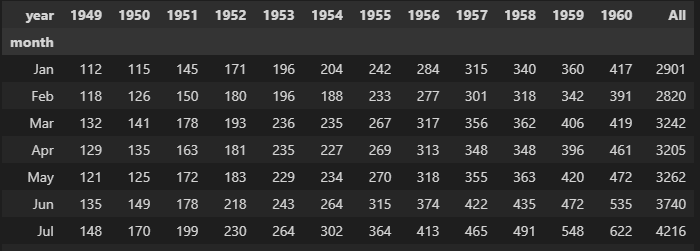

This adds an "All" row and column with totals, and fills missing data with `0`.

---

**✅ When to Use**

- Your data has **duplicate entries** for `(index, column)` combinations.
- You want to **aggregate** values during pivoting.
- You want **summaries**, like totals or averages, across multiple dimensions.

---

**🔁 `.pivot()` vs `.pivot_table()`**

| Feature           | `.pivot()`               | `.pivot_table()`                         |
|------------------|--------------------------|------------------------------------------|
| Handles duplicates | ❌ Raises error         | ✅ Aggregates with `aggfunc`             |
| Aggregation       | ❌ Not supported         | ✅ e.g., `mean()`, `sum()`, `count()`    |
| Performance       | Faster for clean data   | Slightly slower, but more flexible       |


In [ ]:
import seaborn as sns
import pandas as pd

# Load the flights dataset
flights = sns.load_dataset("flights")

# Create pivot table with totals and fill
pivot_with_totals = flights.pivot_table(
    index="month",
    columns="year",
    values="passengers",
    aggfunc="sum",
    fill_value=0,
    margins=True,
    observed=False
)

# Display the result
pivot_with_totals

# observed=False: shows all combinations of categories, even if they're not present in the data. Add for default behavior and future compatibility.

✅ Using observed=True

When your index or columns contain categorical variables, setting observed=True means:

Only the combinations of category levels that actually appear in the data will be included in the result.

This makes the result smaller and often faster to compute — useful for sparse datasets.

**🔍 Comparison**

| Setting          | Behavior                                                                 |
| ---------------- | ------------------------------------------------------------------------ |
| `observed=False` | Includes **all** category combinations (even if not present in the data) |
| `observed=True`  | Includes **only observed** combinations                                  |


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "color": pd.Categorical(["red", "blue", "red"], categories=["red", "blue", "green"]),
    "shape": pd.Categorical(["circle", "circle", "square"], categories=["circle", "square"]),
    "value": [1, 2, 3]
})

# observed=False (default)
pivot_all = pd.pivot_table(df, index="color", columns="shape", values="value", aggfunc="sum", observed=False)

# observed=True
pivot_observed = pd.pivot_table(df, index="color", columns="shape", values="value", aggfunc="sum", observed=True)

print("With observed=False:")
print(pivot_all)

print("\nWith observed=True:")
print(pivot_observed)



# Data Transformation

In [ ]:
# Removing duplicates
# SQL: SELECT DISTINCT * FROM table
df.drop_duplicates()

# SQL: SELECT DISTINCT column1, column2 FROM table
df.drop_duplicates(subset=['column1', 'column2'])

# SQL: UPDATE table SET new_column = CASE WHEN condition THEN value1 ELSE value2 END
df['category'] = np.where(df['total_amount'] > 1000, 'High Value', 'Regular')


# Multiple conditions (SQL: CASE WHEN ... WHEN ... ELSE)
conditions = [
    df['total_amount'] > 2000,
    df['total_amount'] > 1000,
    df['total_amount'] > 500
]
choices = ['Premium', 'High Value', 'Medium Value']
df['customer_tier'] = np.select(conditions, choices, default='Regular')
# A new column customer_tier is added to the DataFrame.
# Each condition is checked in order, and the first match wins. 
# So even if a value is > 2000 and also > 1000, it gets categorized as 'Premium'.
# If none of the conditions match (i.e., total_amount <= 500), it assigns 'Regular'.

# Creating new columns from existing ones
df['profit_margin'] = (df['revenue'] - df['cost']) / df['revenue'] * 100
df['full_name'] = df['first_name'] + ' ' + df['last_name']

# Working with dates
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.day_name()
df['days_since_order'] = (pd.Timestamp.now() - df['order_date']).dt.days

# Binning continuous data (SQL: CASE WHEN with ranges)
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100], 
                        labels=['Young', 'Adult', 'Middle Age', 'Senior'])


### Binning Continuous Data with `pd.cut()`

This example demonstrates how to convert continuous numeric data (like age) into categorical bins:

```python
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 25, 40, 60, 100],
                         labels=['Young', 'Adult', 'Middle Age', 'Senior'])
```
### 🔍 How it Works

- `df['age']`: The numeric column to bin.
- `bins=[0, 25, 40, 60, 100]`: Defines interval edges (exclusive on left, inclusive on right):
  - `(0, 25]` → `'Young'`
  - `(25, 40]` → `'Adult'`
  - `(40, 60]` → `'Middle Age'`
  - `(60, 100]` → `'Senior'`
- `labels=[...]`: Category labels for each bin.
- A new column `age_group` is added with these labels.

> ℹ️ Default bin behavior is **right-inclusive** — values exactly on a bin edge fall into the **higher bin** (e.g., `25` → `'Young'`, `26` → `'Adult'`).

### Why use `pd.cut()`?

| Use Case                        | Why                                      |
| ------------------------------- | ---------------------------------------- |
| Turn numeric ranges into labels | Useful for reporting, modeling, grouping |
| Easy interval definition        | Cleaner than multiple `np.where()` calls |

